In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import networkx as nx

from edward.models import Normal, Poisson, Bernoulli, InverseGamma
import collections

In [2]:
x_train = np.array([[0,1,1,0,0,0],
                    [1,0,1,0,0,0],
                    [1,1,0,0,0,0],
                    [0,0,0,0,1,1],
                    [0,0,0,1,0,1],
                    [0,0,0,1,1,0]])

In [2]:
x_train = np.array([[0,1,0,0,0,0],
                    [1,0,0,0,0,0],
                    [0,0,0,0,0,0],
                    [0,0,0,0,0,0],
                    [0,0,0,0,0,0],
                    [0,0,0,0,0,0]])

## Test with b parameter only

In [3]:
N = x_train.shape[0]
b = Normal(loc = tf.zeros(1), scale = tf.ones(1))
x = Bernoulli(logits = b*tf.ones([N,N]))

In [4]:
qb = Normal(loc=tf.get_variable("qb/loc", 1),
             scale=tf.nn.softplus(tf.get_variable("qb/scale", 1)))

inference = ed.KLqp({b: qb}, data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [5]:
n_iter = 500
inference.initialize(n_iter=n_iter)
tf.global_variables_initializer().run()
info_loss = np.zeros(n_iter)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  info_loss[_] = info_dict['loss']

inference.finalize()

500/500 [100%] ██████████████████████████████ Elapsed: 0s | Loss: 10.974

In [6]:
print("True sparcity:",np.mean(x_train))
print("qb sparcity:",(tf.sigmoid(qb.mean())).eval())
print("b sparcity:",(tf.sigmoid(b.mean())).eval())

True sparcity: 0.05555555555555555
qb sparcity: [0.10299224]
b sparcity: [0.5]


## Full model test with scale

In [3]:
N = x_train.shape[0]  # number of data points
K = 4  # latent dimensionality

scale_z = InverseGamma(tf.ones([1,K])*1e-3, tf.ones([1,K])*1e-3) 
scale_b = InverseGamma([1e-3], [1e-3]) #Gelman 2006

z2 = Normal(loc = tf.zeros([N, K]), scale = (tf.sqrt(scale_z)*tf.ones([N, K]))) #Tjek søjle
z1 = Normal(loc = tf.zeros([N, K]), scale = (tf.sqrt(scale_z)*tf.ones([N, K])))
b = Normal(loc = tf.zeros(1), scale = (tf.sqrt(scale_b)*tf.ones(1)))

pi1 = tf.tile(tf.reduce_sum(tf.pow(z1, 2), 1, keepdims=True), [1, N])
pi2 = tf.tile(tf.reduce_sum(tf.pow(z2, 2), 1, keepdims=True), [1, N])        
           
pi = pi1 + tf.transpose(pi2) - 2 * tf.matmul(z1, z2, transpose_b=True)

pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3))
#pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3) + 1e-9) + b

#pi[pi>1e100] = 1e100 #skal testes
#pi[pi<1e-100] = 1e-100

#pi = -(pi + tf.diag(tf.zeros(N) + 1e3) + 1e-5)

pi = tf.sigmoid(pi + b) #med bias (mange eller få links)

#x = Bernoulli(logits = pi)
x = Bernoulli(probs = pi)

In [4]:
qz1 = Normal(loc=tf.get_variable("qz1/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz1/scale", [N, K])))
qz2 = Normal(loc=tf.get_variable("qz2/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz2/scale", [N, K])))
qb = Normal(loc=tf.get_variable("qb/loc", 1),
             scale=tf.nn.softplus(tf.get_variable("qb/scale", 1)))

qscale_z = Normal(loc=tf.get_variable("qscale_z/loc", [1, K]),
             scale=tf.nn.softplus(tf.get_variable("qscale_z/scale", [1, K])))

qscale_b = Normal(loc=tf.get_variable("qscale_b/loc", 1),
             scale=tf.nn.softplus(tf.get_variable("qscale_b/scale", 1)))

inference = ed.KLqp({z1: qz1,
                     z2: qz2,
                     scale_z: qscale_z,
                     scale_b: qscale_b,
                     b: qb},
                     data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [5]:
n_iter = 200
inference.initialize(n_iter=n_iter)
tf.global_variables_initializer().run()
info_loss = np.zeros(n_iter)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  info_loss[_] = info_dict['loss']

inference.finalize()

200/200 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 56.496

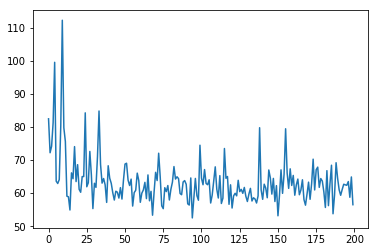

In [6]:
plt.plot(info_loss)
plt.show()

In [7]:
sess = ed.get_session()
x_post = ed.copy(pi, {z1: qz1,
                     z2: qz2,
                     scale_z: qscale_z,
                     scale_b: qscale_b,
                     b: qb})
x_gen = sess.run(x_post)

In [9]:
x_gen

array([[7.6478191e-14, 3.6801386e-01, 2.4649154e-01, 3.1744692e-01,
        2.4593587e-01, 3.6281556e-01],
       [2.9892778e-01, 8.5864807e-14, 4.0927154e-01, 6.4758092e-01,
        3.7731925e-01, 4.2834976e-01],
       [3.9967239e-01, 4.1479167e-01, 8.6057788e-14, 4.1486433e-01,
        5.2676541e-01, 4.4946226e-01],
       [1.8690550e-01, 2.7302426e-01, 2.8157061e-01, 8.5061020e-14,
        2.2552757e-01, 2.0801559e-01],
       [4.3689227e-01, 7.0690095e-01, 4.1468820e-01, 4.0583131e-01,
        8.4905410e-14, 4.3864653e-01],
       [3.3187264e-01, 7.0709205e-01, 4.0064815e-01, 4.3262079e-01,
        4.3371588e-01, 8.6071246e-14]], dtype=float32)

In [40]:
x.eval()

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int32)

## Full model test without scale

In [3]:
N = x_train.shape[0]  # number of data points
K = 3  # latent dimensionality

#scale_z = InverseGamma(tf.ones([1,K])*1e-3, tf.ones([1,K])*1e-3) 
#scale_b = InverseGamma([1e-3], [1e-3]) #Gelman 2006

z2 = Normal(loc = tf.zeros([N, K]), scale = (tf.ones([N, K]))) #Tjek søjle
z1 = Normal(loc = tf.zeros([N, K]), scale = (tf.ones([N, K])))
b = Normal(loc = tf.zeros(1), scale = (tf.ones(1)))

pi1 = tf.tile(tf.reduce_sum(tf.pow(z1, 2), 1, keepdims=True), [1, N])
pi2 = tf.tile(tf.reduce_sum(tf.pow(z2, 2), 1, keepdims=True), [1, N])        
           
pi = pi1 + tf.transpose(pi2) - 2 * tf.matmul(z1, z2, transpose_b=True)

pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3))
#pi = -tf.sqrt(pi + tf.diag(tf.zeros(N) + 1e3) + 1e-9) + b

#pi[pi>1e100] = 1e100 #skal testes
#pi[pi<1e-100] = 1e-100

#pi = -(pi + tf.diag(tf.zeros(N) + 1e3) + 1e-5)

pi = tf.sigmoid(pi + b) #med bias (mange eller få links)

#x = Bernoulli(logits = pi)
x = Bernoulli(probs = pi)

In [4]:
qz1 = Normal(loc=tf.get_variable("qz1/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz1/scale", [N, K])))
qz2 = Normal(loc=tf.get_variable("qz2/loc", [N, K]),
             scale=tf.nn.softplus(tf.get_variable("qz2/scale", [N, K])))
qb = Normal(loc=tf.get_variable("qb/loc", 1),
             scale=tf.nn.softplus(tf.get_variable("qb/scale", 1)))

inference = ed.KLqp({z1: qz1,
                     z2: qz2,
                     b: qb},
                     data={x: x_train})

/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/anaconda/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [5]:
n_iter = 200
inference.initialize(n_iter=n_iter)
tf.global_variables_initializer().run()
info_loss = np.zeros(n_iter)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  info_loss[_] = info_dict['loss']

inference.finalize()

200/200 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 24.664

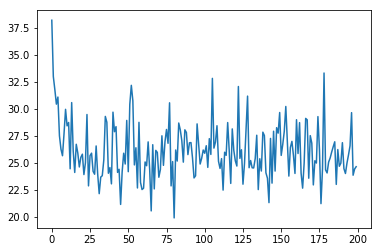

In [6]:
plt.plot(info_loss)
plt.show()

In [7]:
sess = ed.get_session()
x_post = ed.copy(x, {z1: qz1,
                     z2: qz2,
                     b: qb})
x_gen = sess.run(x_post)

In [8]:
print("qb:",(tf.sigmoid(qb.mean())).eval())

qb sparcity: [0.71002984]
